# Imports

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm import tqdm
from typing import Optional, List, Union # type tips

# Load Data

In [134]:
# df is the non-normalized passive data with features and target 
df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_passive_fe.csv')

# mlm_gap_df is the results of the MLM on the gap data
mlm_gap_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
mlm_affect_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_affect_results_df.csv')

## Train-Test Split

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

In [135]:
# Get last day of data collection for each PID based on unlock duration data
last_days = df.groupby('PID').agg({
    'day': lambda x: x[df['passive_sk_device_total_unlock_duration'].notna()].max()
}).reset_index()

# Remove any data after each PID's last day
tt_filtered = pd.merge(
    df,
    last_days,
    on='PID',
    suffixes=('', '_last')
)
tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]

# Create train/test splits for each PID
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for pid in tt_filtered['PID'].unique():
    pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
    
    # Sort by day to ensure chronological split
    pid_data = pid_data.sort_values('day')
    
    # Calculate split point at 80%
    split_idx = int(len(pid_data) * 0.8)
    
    # Split the data
    train_pid = pid_data.iloc[:split_idx]
    test_pid = pid_data.iloc[split_idx:]
    
    # Append to main dataframes
    train_data = pd.concat([train_data, train_pid])
    test_data = pd.concat([test_data, test_pid])

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of unique PIDs in training: {train_data['PID'].nunique()}")
print(f"Number of unique PIDs in test: {test_data['PID'].nunique()}")

Training set size: 5141
Test set size: 1350
Number of unique PIDs in training: 105
Number of unique PIDs in test: 105


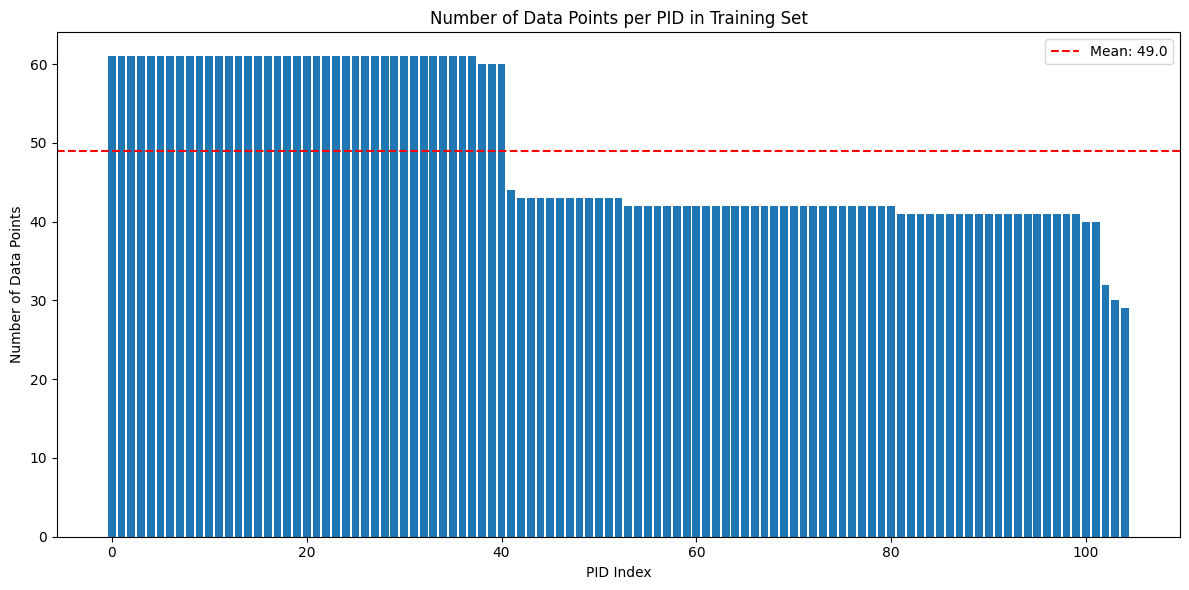

In [136]:
# Count data points per PID in training set
pid_counts = train_data['PID'].value_counts()

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pid_counts)), pid_counts.values)
plt.xlabel('PID Index')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per PID in Training Set')

# Add mean line
mean_points = pid_counts.mean()
plt.axhline(y=mean_points, color='r', linestyle='--', label=f'Mean: {mean_points:.1f}')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [137]:
# Check for empty, binary (0/1) columns and non-numeric columns
empty_cols = []
binary_cols = []
non_numeric_cols = []

for col in train_data.columns:
    # Check if column is empty (all NaN)
    if train_data[col].isna().all():
        empty_cols.append(col)
        continue
        
    # Check if column is non-numeric
    if not np.issubdtype(train_data[col].dtype, np.number):
        non_numeric_cols.append(col)
        continue
        
    # Check if column only contains 0s and 1s
    unique_vals = train_data[col].unique()
    unique_vals = unique_vals[~np.isnan(unique_vals)]  # Remove NaN values
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

print("Empty columns:")
print(empty_cols)
print("\nBinary columns:")
print(binary_cols)
print("\nNon-numeric columns:")
print(non_numeric_cols)


Empty columns:
[]

Binary columns:
['survey_complete', 'tasks_complete', 'watch_wearing', 'weekend', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'fe_lag_1_survey_complete', 'fe_lag_2_survey_complete', 'fe_lag_3_survey_complete', 'fe_lag_1_tasks_complete', 'fe_lag_2_tasks_complete', 'fe_lag_3_tasks_complete', 'fe_lag_1_watch_wearing', 'fe_lag_2_watch_wearing', 'fe_lag_3_watch_wearing']

Non-numeric columns:
['PID', 'trial_date', 'cohort']


# Functions

In [138]:
def expanding_window_cv_nested(df: pd.DataFrame, validation_days: int = 15) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Performs expanding window cross-validation accounting for nested observations within subjects.
    Creates 5 splits, each moving forward by 3 days and using 3 days for validation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Training data containing 'PID' and 'day' columns
    validation_days : int
        Number of days to use for validation windows
        
    Returns:
    --------
    list of tuples
        Each tuple contains (train_idx, val_idx) for one fold, 
        where indices from all subjects are combined
    """
    # Dictionary to store splits by window position
    window_splits = {}  # {window_position: [(train_idx, val_idx), ...]}
    
    # Process each subject separately
    for pid in df['PID'].unique():
        # Get data for this subject
        subject_data = df[df['PID'] == pid].copy()
        
        # Get sorted unique days for this subject
        subject_days = sorted(subject_data['day'].unique())
        n_days = len(subject_days)
        
        # Skip subjects with too few observations
        if n_days < 25:  # means min of 10 days in initial training
            continue
            
        # Determine window days for this subject
        window_start_idx = max(0, n_days - validation_days)
        window_days = subject_days[window_start_idx:]
        
        # Create 5 splits, moving forward by 3 days each time
        for window_pos in range(0, 5):  # 5 splits
            val_start_idx = window_start_idx + (window_pos * 3)  # Move forward by 3 days each time
            
            # Skip if we don't have enough days left
            if val_start_idx + 3 > len(subject_days):
                continue
                
            # Get 3 validation days
            val_days = subject_days[val_start_idx:val_start_idx + 3]
            
            # Get training days (all days up to validation period)
            train_days = subject_days[:val_start_idx]
            
            # Get indices for this split
            train_mask = (df['PID'] == pid) & (df['day'].isin(train_days))
            val_mask = (df['PID'] == pid) & (df['day'].isin(val_days))
            
            # Convert to indices
            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]
            
            # Only add split if we have both training and validation data
            if len(train_idx) > 0 and len(val_idx) > 0:
                # Add to window_splits dictionary
                if window_pos not in window_splits:
                    window_splits[window_pos] = []
                window_splits[window_pos].append((train_idx, val_idx))
    
    # Combine splits for each window position
    combined_splits = []
    for window_pos in sorted(window_splits.keys()):
        # Combine all train indices and all val indices for this window position
        all_train_idx = np.concatenate([split[0] for split in window_splits[window_pos]])
        all_val_idx = np.concatenate([split[1] for split in window_splits[window_pos]])
        combined_splits.append((all_train_idx, all_val_idx))
    
    return combined_splits

# Data Preprocessing

## Clean Data

In [139]:
# remove subject `c8b323ca-be8b-4374-ab2c-b4788e4a0e3d` who has NO watch data
train_data = train_data[train_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']
test_data = test_data[test_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']

In [148]:
# Drop rows with missing values in t_current
train_data_clean = train_data.dropna(subset=['t_current'])
test_data_clean = test_data.dropna(subset=['t_current'])

## Feature Engineering

In [149]:
# Add each PID's median gap in training data to each row in training data
median_train_gaps = train_data_clean.groupby('PID')['t_current'].median().reset_index().rename(columns={'t_current': 'median_gap'})

train_data_clean = pd.merge(train_data_clean, median_train_gaps, on='PID', how='left')
test_data_clean = pd.merge(test_data_clean, median_train_gaps, on='PID', how='left')

# Add each PID's gap SD in training data to each row in training/test data
sd_train_gaps = train_data_clean.groupby('PID')['t_current'].std().reset_index().rename(columns={'t_current': 'sd_gap'})
train_data_clean = pd.merge(train_data_clean, sd_train_gaps, on='PID', how='left')
test_data_clean = pd.merge(test_data_clean, sd_train_gaps, on='PID', how='left')

## Create CV folds

In [142]:
# Create CV folds
cv_folds = expanding_window_cv_nested(train_data_clean)

## Select Features

In [168]:
# Filter features from mlm_gap_df where abs_t_value > 2 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

# Add mean gap to features
features.append('median_gap')
features.append('sd_gap')

Selected 65 features with |t| > 2 (excluding css features):


In [169]:
features

['passive_hk_activity_distanceWalkingRunning',
 'passive_hk_activity_steps',
 'passive_sk_device_total_screen_wakes',
 'passive_hk_activity_appleStandTime',
 'passive_hk_activity_activeEnergyBurned',
 'passive_sk_device_total_unlocks',
 'passive_hk_activity_averageWalkingSpeed',
 'fe_rollingMean_3_passive_sk_device_total_unlock_duration',
 'fe_rollingMean_5_passive_sk_device_total_unlock_duration',
 'passive_sk_visits_work_elapsed',
 'passive_sk_visits_home_elapsed',
 'fe_rollingMean_3_passive_hk_activity_distanceWalkingRunning',
 'fe_rollingMean_3_passive_hk_activity_steps',
 'passive_sk_device_total_usage_entertainment',
 'fe_rollingMean_3_passive_sk_device_total_screen_wakes',
 'fe_rollingMean_5_passive_sk_device_total_usage_entertainment',
 'fe_rollingMean_5_passive_hk_activity_distanceWalkingRunning',
 'fe_rollingMean_3_passive_sk_device_total_usage_entertainment',
 'fe_rollingMean_5_passive_hk_activity_steps',
 'passive_sk_device_total_unlock_duration',
 'fe_rollingMean_5_passive

In [174]:
# list of features that do not include string 'fe'
features = [f for f in features if 'fe' not in f]

# remove weekend and day_of_week_4
features = [f for f in features if f not in ['weekend', 'day_of_week_4']]

# add t_current to features
features.append('t_current')

['passive_hk_activity_distanceWalkingRunning',
 'passive_hk_activity_steps',
 'passive_sk_device_total_screen_wakes',
 'passive_hk_activity_appleStandTime',
 'passive_hk_activity_activeEnergyBurned',
 'passive_sk_device_total_unlocks',
 'passive_hk_activity_averageWalkingSpeed',
 'passive_sk_visits_work_elapsed',
 'passive_sk_visits_home_elapsed',
 'passive_sk_device_total_usage_entertainment',
 'passive_sk_device_total_unlock_duration',
 'passive_sk_device_total_usage_education',
 'watch_wearing',
 'passive_sk_messages_incoming',
 'passive_sk_visits_unknown_count',
 'passive_sk_device_total_usage_health_and_fitness',
 'passive_sk_device_total_usage_travel',
 'median_gap',
 'sd_gap',
 't_current']

In [162]:
# Split data
X_train = train_data_clean[features]
y_train = train_data_clean['t_current']

X_test = test_data_clean[features]
y_test = test_data_clean['t_current']

# XGBoost

## Overfit

In [154]:
# Import XGBoost
import xgboost as xgb

In [155]:
# Create and train XGBoost model with parameters that will cause extreme overfitting
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,        # Increased number of trees
    learning_rate=0.3,        # Increased learning rate
    max_depth=15,            # Much deeper trees
    min_child_weight=1,      # Allow very specific splits
    subsample=1.0,           # Use all samples for each tree
    colsample_bytree=1.0,    # Use all features for each tree
    reg_alpha=0,             # No L1 regularization
    reg_lambda=0,            # No L2 regularization
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions on both train and test sets
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

XGBoost Results:
Training RMSE: 0.001
Training MAE: 0.000
Test RMSE: 17.131
Test MAE: 13.225


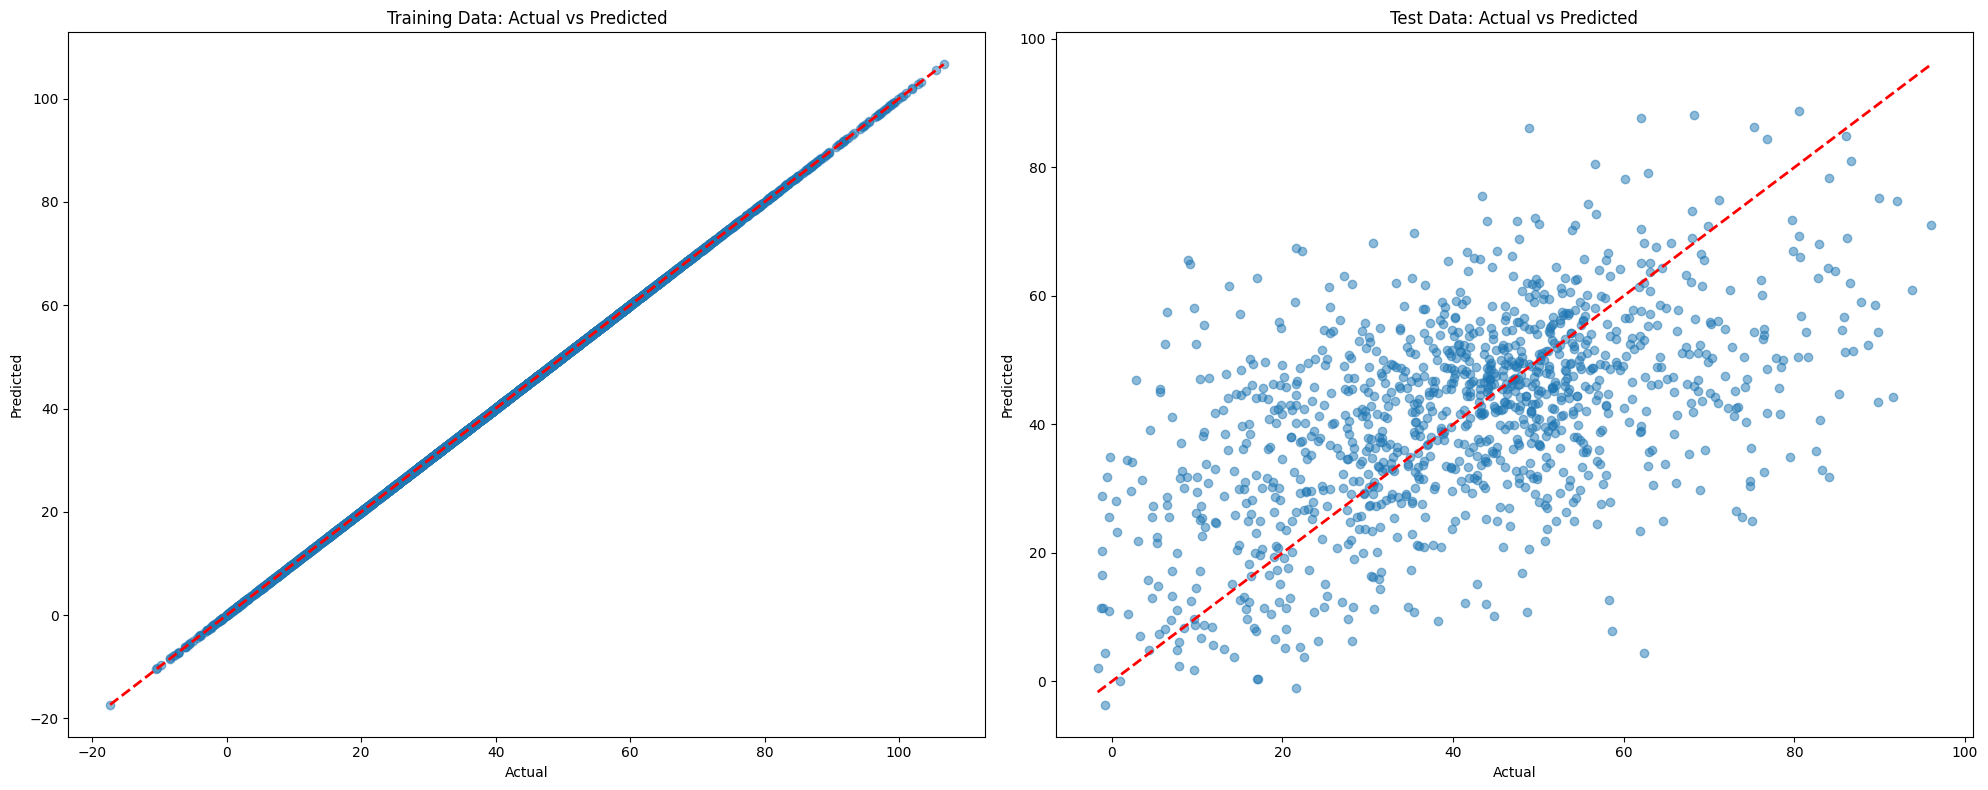

In [156]:
# Calculate metrics for training data
train_rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
train_mae = np.mean(np.abs(y_train - y_pred_train))

# Calculate metrics for test data
test_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
test_mae = np.mean(np.abs(y_test - y_pred_test))

print("XGBoost Results:")
print(f"Training RMSE: {train_rmse:.3f}")
print(f"Training MAE: {train_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}") 
print(f"Test MAE: {test_mae:.3f}")

# Plot actual vs predicted for both train and test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training data plot
ax1.scatter(y_train, y_pred_train, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Training Data: Actual vs Predicted')

# Test data plot
ax2.scatter(y_test, y_pred_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Data: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [131]:
# give the model the normalized passive data and the raw mean and sd for each subject for ALL training data

# how well does this do versus something that just has the mean of the gap

# what if you ONLY knew about their passive data...can we predict their mean??

# how much data about someones mean do we need in order to predict their gap?
## i.e. one day of data re: their gap, what about 1 week, all training data?

#----#

# Look at an individual model using XGBoost - use hyperparameters from group?
# Combine individual and group (experiment with combination level)

## Fitted

[I 2025-01-09 06:27:20,542] A new study created in memory with name: no-name-f39eef66-9d27-45eb-bbd7-5ccc354989f5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-09 06:27:22,959] Trial 0 finished with value: 15.978717832759695 and parameters: {'n_estimators': 115, 'max_depth': 6, 'learning_rate': 0.08488548415087607, 'min_child_weight': 3, 'subsample': 0.7839547655754177, 'colsample_bytree': 0.7286960078449655, 'reg_alpha': 0.2231900799940402}. Best is trial 0 with value: 15.978717832759695.
[I 2025-01-09 06:27:26,238] Trial 1 finished with value: 15.793987215851946 and parameters: {'n_estimators': 219, 'max_depth': 4, 'learning_rate': 0.03295657038899229, 'min_child_weight': 2, 'subsample': 0.9473370591513908, 'colsample_bytree': 0.781002282377687, 'reg_alpha': 0.2176541161406779}. Best is trial 1 with value: 15.793987215851946.
[I 2025-01-09 06:27:30,559] Trial 2 finished with value: 15.82144208736174 and parameters: {'n_estimators': 195, 'max_depth': 5, 'learning_rate': 0.018681298800995453, 'min_child_weight': 1, 'subsample': 0.7463362177891353, 'colsample_bytree': 0.7391090344260719, 'reg_alpha': 0.7635137281107851}. Best is tri

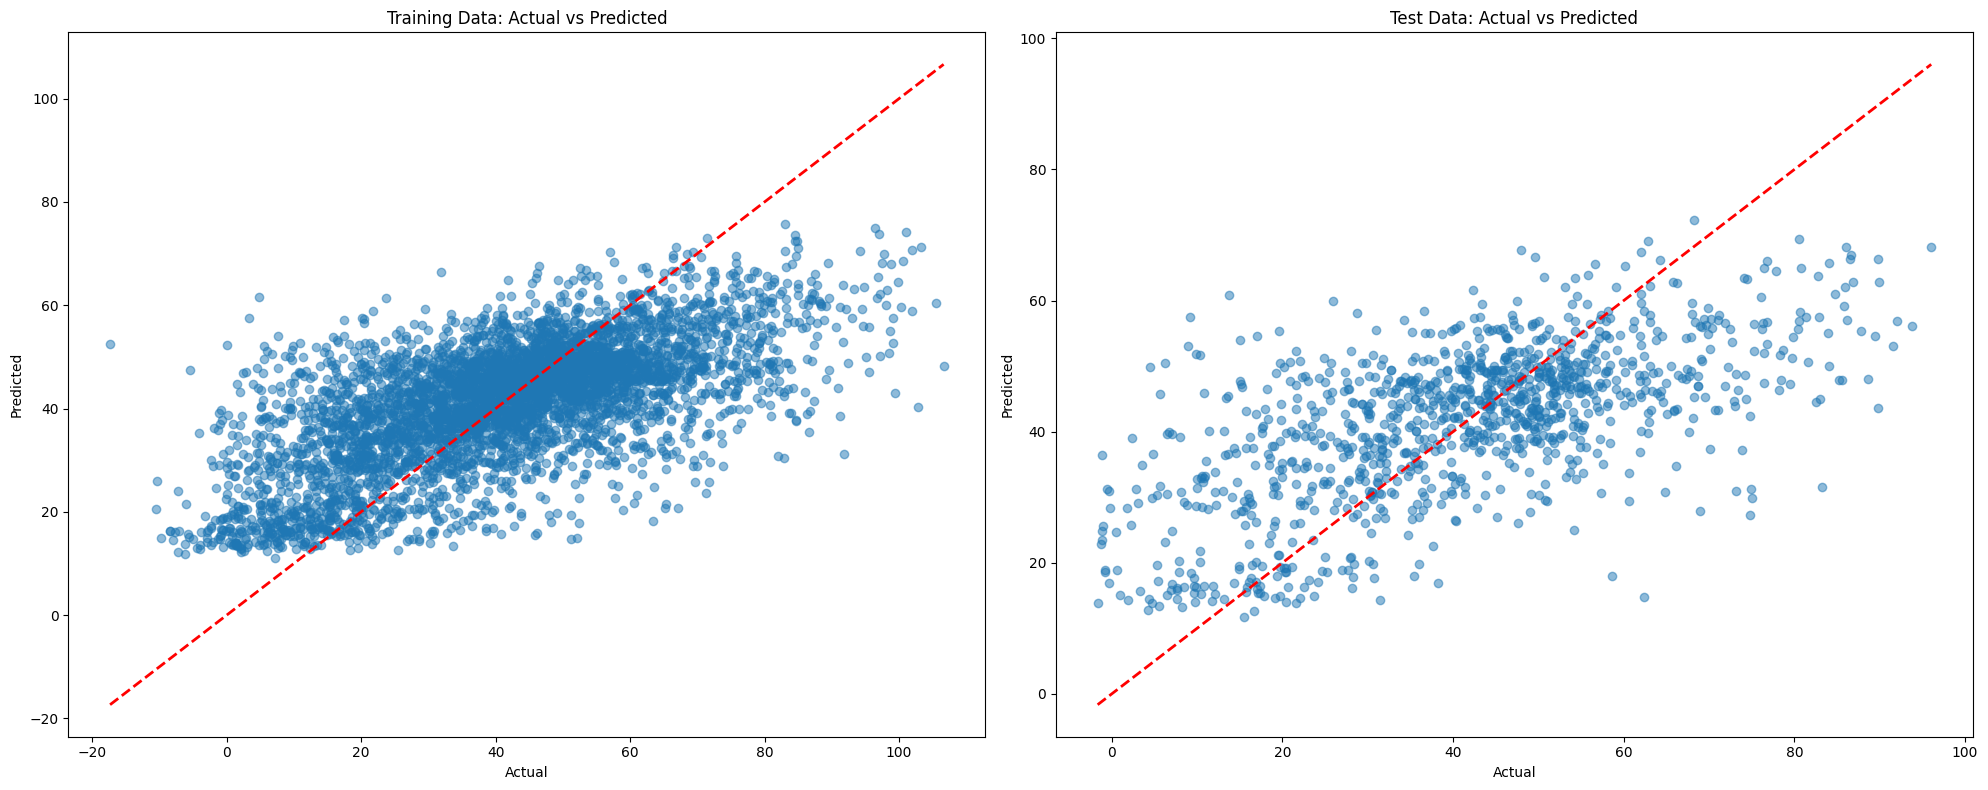

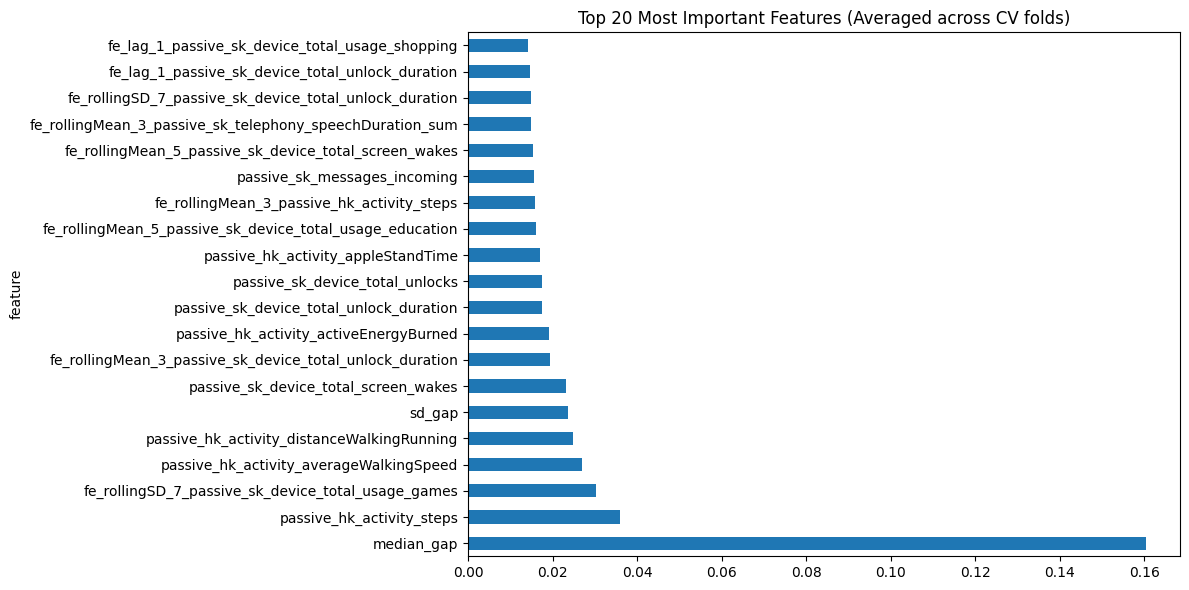

In [163]:
# Import required libraries
import optuna
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial, X, y, cv_folds):
    # Define hyperparameter search space with balanced ranges
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 6),  # Moderate depth
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Moderate learning rate
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),  # Balanced min_child_weight
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Moderate subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # Moderate feature sampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0.2, 1.0, log=True),  # Moderate L1
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0.2, 1.0, log=True),  # Moderate L2
        'random_state': 42,
        'early_stopping_rounds': 30  # Balanced early stopping
    }
    
    fold_scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in cv_folds:
        model = xgb.XGBRegressor(**params)
        model.fit(
            X.iloc[train_idx], 
            y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False
        )
        
        # Evaluate on validation set
        val_preds = model.predict(X.iloc[val_idx])
        fold_score = np.sqrt(mean_squared_error(y.iloc[val_idx], val_preds))
        fold_scores.append(fold_score)
    
    return np.mean(fold_scores)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, X_train, y_train, cv_folds), 
    n_trials=50,
    show_progress_bar=True
)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 30
})

print("\nBest parameters found:", best_params)

# Train final model with best parameters using cross-validation
cv_scores = []
cv_models = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
    fold_model = xgb.XGBRegressor(**best_params)
    fold_model.fit(
        X_train.iloc[train_idx], 
        y_train.iloc[train_idx],
        eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
        verbose=False
    )
    cv_models.append(fold_model)
    
    # Calculate fold score
    val_preds = fold_model.predict(X_train.iloc[val_idx])
    fold_score = np.sqrt(mean_squared_error(y_train.iloc[val_idx], val_preds))
    cv_scores.append(fold_score)

# Use model averaging for final predictions
y_pred_train = np.mean([model.predict(X_train) for model in cv_models], axis=0)
y_pred_test = np.mean([model.predict(X_test) for model in cv_models], axis=0)

# Calculate and print metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nCross-validation RMSE scores:", cv_scores)
print(f"Mean CV RMSE: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
print("\nFinal Model Results:")
print(f"Training RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Training MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")

# Plot actual vs predicted for both train and test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training data plot
ax1.scatter(y_train, y_pred_train, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Training Data: Actual vs Predicted')

# Test data plot
ax2.scatter(y_test, y_pred_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Data: Actual vs Predicted')

plt.tight_layout()
plt.show()

# Plot feature importance
importance_dfs = []
for model in cv_models:
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    })
    importance_dfs.append(importance_df)

avg_importance = pd.concat(importance_dfs).groupby('feature')['importance'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_importance.head(20).plot(kind='barh')
plt.title('Top 20 Most Important Features (Averaged across CV folds)')
plt.tight_layout()
plt.show()

# GPBoost

From [this article](https://towardsdatascience.com/tree-boosted-mixed-effects-models-4df610b624cb)

In [111]:
import gpboost as gpb

## Clean Data

In [126]:
# remove subject `c8b323ca-be8b-4374-ab2c-b4788e4a0e3d` who has NO watch data
train_data = train_data[train_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']
test_data = test_data[test_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']

In [127]:
# Drop rows with missing values in t_current
train_data_clean = train_data.dropna(subset=['t_current'])
test_data_clean = test_data.dropna(subset=['t_current'])

## Select Features

In [128]:
# Filter features from mlm_gap_df where abs_t_value > 2 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

Selected 65 features with |t| > 2 (excluding css features):


## Model

Setting up GPBoost model...

Estimated random effects model: 
Covariance parameters (random effects):
              Param.
Error_term  259.6759
Group_1     136.7175


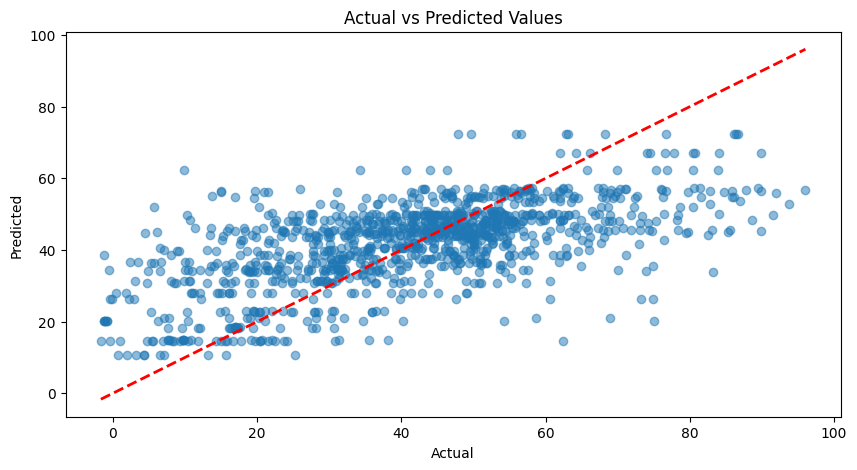


Feature importances: [100, 100, 0, 0, 191, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 100]


[I 2025-01-08 15:39:57,343] A new study created in memory with name: no-name-627f6b59-1cb6-4d6b-9a5e-eb260e5b527b



Optimizing parameters...


[I 2025-01-08 15:40:04,965] Trial 0 finished with value: 267.08013174525905 and parameters: {'learning_rate': 0.013351494520010323, 'min_data_in_leaf': 23, 'max_depth': 2, 'num_leaves': 7, 'lambda_l2': 7.337794540855652, 'max_bin': 76}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:40:23,862] Trial 1 finished with value: 267.5260388685757 and parameters: {'learning_rate': 0.003182077285755199, 'min_data_in_leaf': 3, 'max_depth': 4, 'num_leaves': 24, 'lambda_l2': 20.95972572016474, 'max_bin': 264}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:40:33,057] Trial 2 finished with value: 267.5616701089681 and parameters: {'learning_rate': 0.0035629562476919238, 'min_data_in_leaf': 53, 'max_depth': 2, 'num_leaves': 47, 'lambda_l2': 20.865240118356347, 'max_bin': 202}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:42:08,676] Trial 3 finished with value: 267.5578486460375 and parameters: {'learning_rate': 0.0023927654893085163, 'min_data_


Best parameters: {'learning_rate': 0.4502961910373316, 'min_data_in_leaf': 7, 'max_depth': 8, 'num_leaves': 191, 'lambda_l2': 1.3045301643060254, 'max_bin': 205}
Best iteration: 660
Best score: [256.7886727161154]
[GPBoost] [Info] Total Bins 12516
[GPBoost] [Info] Number of data points in the train set: 4814, number of used features: 65
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=41.458249
[GPBoost] [Info] Start training from score 41.458249

Final Model Performance:
Test RMSE: 14.9961
Test MAE: 11.6083


In [129]:
print('Setting up GPBoost model...')

# Prepare data
X_train = train_data_clean[features].values
y_train = train_data_clean['t_current'].values
X_test = test_data_clean[features].values 
y_test = test_data_clean['t_current'].values

# Create PID to numeric index mapping for group data
pid_to_idx = {pid: idx for idx, pid in enumerate(train_data_clean['PID'].unique())}
group_train = train_data_clean['PID'].map(pid_to_idx).values
group_test = test_data_clean['PID'].map(pid_to_idx).values

#--------------------Training----------------
# Define GPModel with random effects grouped by PID
gp_model = gpb.GPModel(group_data=group_train, likelihood="gaussian")

# Train initial model with default parameters
params = {
    'objective': 'regression_l2',
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_data_in_leaf': 5,
    'verbose': 0
}

# Create dataset
train_data = gpb.Dataset(X_train, y_train)

# Train model
bst = gpb.train(params=params,
                train_set=train_data,
                gp_model=gp_model,
                num_boost_round=100)

print("\nEstimated random effects model: ")
gp_model.summary()

#--------------------Prediction----------------
# Make predictions
pred = bst.predict(data=X_test, 
                  group_data_pred=group_test,
                  pred_latent=True)  # Get both fixed and random effects

# Calculate and plot actual vs predicted
plt.figure(figsize=(10, 5))
y_pred = pred['fixed_effect'] + pred['random_effect_mean']
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Print feature importances
print('\nFeature importances:', list(bst.feature_importance()))

#--------------------Parameter Tuning----------------
# Define search space based on GPBoost documentation
search_space = {
    'learning_rate': [0.001, 0.5],
    #'min_data_in_leaf': [1, 100],
    'min_child_weight': [1, 100],
    'max_depth': [2, 8],
    'num_leaves': [2, 256],
    'lambda_l2': [0, 50],
    'max_bin': [63, 512]
}

# Define metric
metric = "mse" # Can also use metric = "test_neg_log_likelihood". For more options, see https://github.com/fabsig/GPBoost/blob/master/docs/Parameters.rst#metric-parameters

gp_model = gpb.GPModel(group_data=group_train, likelihood="gaussian")

# Create validation split using last 20% of data for each PID
train_tune_idx = []
valid_tune_idx = []

# Create folds
folds = expanding_window_cv_nested(train_data_clean)

# Run parameter optimization
print('\nOptimizing parameters...')
opt_params = gpb.tune_pars_TPE_algorithm_optuna(
    X=X_train,
    y=y_train,
    search_space=search_space,
    folds=folds,
    gp_model=gp_model,
    metric=metric,
    tpe_seed=1,
    max_num_boost_round=1000,
    n_trials=100,
    early_stopping_rounds=20
)

print("\nBest parameters:", str(opt_params['best_params']))
print("Best iteration:", str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))

# Train final model with best parameters
final_params = opt_params['best_params']
final_params.update({'n_estimators': opt_params['best_iter']})
final_model = gpb.train(params=final_params,
                       train_set=train_data,
                       gp_model=gp_model)

# Make final predictions
final_pred = final_model.predict(data=X_test, 
                               group_data_pred=group_test,
                               pred_latent=True)
y_pred = final_pred['fixed_effect'] + final_pred['random_effect_mean']

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"\nFinal Model Performance:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

In [ ]:
print("\nBest parameters:", str(opt_params['best_params']))
print("Best iteration:", str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))

# Train final model with best parameters
final_params = opt_params['best_params']
final_model = gpb.train(params=final_params,
                       train_set=train_data,
                       gp_model=gp_model)

# Make final predictions
final_pred = final_model.predict(data=X_test, 
                               group_data_pred=group_test,
                               pred_latent=True)
y_pred = final_pred['fixed_effect'] + final_pred['random_effect_mean']

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"\nFinal Model Performance:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Best parameters: {'learning_rate': 0.40786420567450793, 'min_data_in_leaf': 56, 'max_depth': 7, 'num_leaves': 73, 'lambda_l2': 0.011713989534268138, 'max_bin': 440, 'n_estimators': 1000}
Best iteration: 1000
Best score: [256.50969852823147]
[GPBoost] [Info] Total Bins 28171
[GPBoost] [Info] Number of data points in the train set: 4871, number of used features: 68
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=41.620864
[GPBoost] [Info] Start training from score 41.620864


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/gpboost/engine.py:188: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



Final Model Performance:
Test RMSE: 15.0011
Test MAE: 11.5999


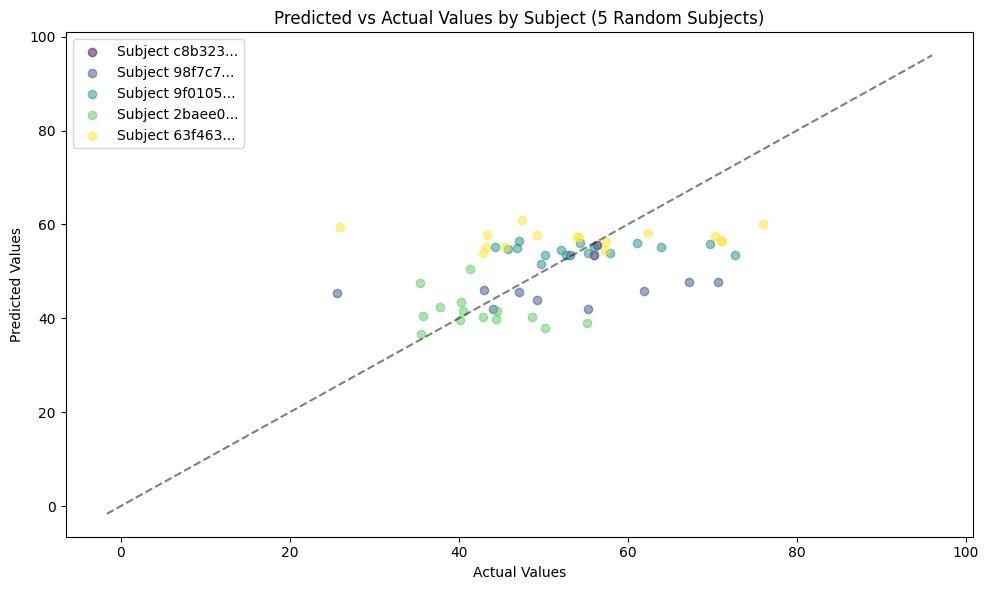

In [ ]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))

# Get unique PIDs and randomly select 5
unique_pids = test_data_clean['PID'].unique()
selected_pids = np.random.choice(unique_pids, size=5, replace=False)

# Create color map for selected PIDs
pid_colors = plt.cm.viridis(np.linspace(0, 1, 5))
pid_color_map = dict(zip(selected_pids, pid_colors))

# Plot points colored by PID for selected PIDs only
for pid in selected_pids:
    mask = test_data_clean['PID'] == pid
    plt.scatter(test_data_clean['t_current'][mask], y_pred[mask], 
               color=pid_color_map[pid], 
               alpha=0.5,
               label=f'Subject {pid[:6]}...')

# Add perfect prediction line
min_val = min(test_data_clean['t_current'].min(), y_pred.min())
max_val = max(test_data_clean['t_current'].max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values by Subject (5 Random Subjects)')
plt.legend()

plt.tight_layout()
plt.show()


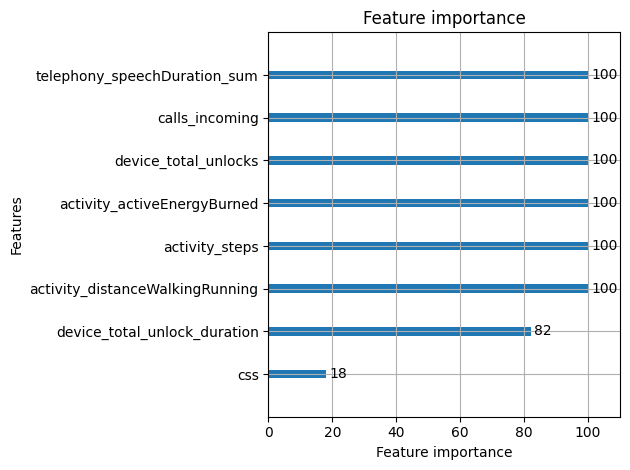

In [ ]:
# Get feature names 
feature_names = features

# Create feature importance plot with actual column names
ax = gpb.plot_importance(bst)

# Get current y-tick labels (which are like "Column_X")
current_labels = ax.get_yticklabels()

# Map the Column_X numbers to actual feature names
new_labels = []
for label in current_labels:
    # Extract the number from "Column_X"
    column_num = int(label.get_text().split('_')[1])
    # Get corresponding feature name
    new_labels.append(feature_names[column_num])

# Set new labels
new_labels = [label.split('passive_', 1)[1][3:] if 'passive_' in label else label for label in new_labels]
ax.set_yticklabels(new_labels)

plt.tight_layout()
plt.show()